# IMPORTS

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt

import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score


# LOAD THE DATA

In [3]:
file_path = "hypertension_dataset.csv"
data = pd.read_csv(file_path)
data.head(10)

,Age,Salt_Intake,Stress_Score,BP_History,Sleep_Duration,BMI,Medication,Family_History,Exercise_Level,Smoking_Status,Has_Hypertension
0,69,8.0,9,Normal,6.4,25.8,None,Yes,Low,Non-Smoker,Yes
1,32,11.7,10,Normal,5.4,23.4,None,No,Low,Non-Smoker,No
2,78,9.5,3,Normal,7.1,18.7,None,No,Moderate,Non-Smoker,No
3,38,10.0,10,Hypertension,4.2,22.1,ACE Inhibitor,No,Low,Non-Smoker,Yes
4,41,9.8,1,Prehypertension,5.8,16.2,Other,No,Moderate,Non-Smoker,No
5,20,10.8,3,Hypertension,5.2,21.9,Beta Blocker,Yes,High,Non-Smoker,Yes
6,39,8.9,0,Normal,7.8,27.6,Beta Blocker,Yes,High,Non-Smoker,No
7,70,5.9,1,Hypertension,7.2,25.8,None,No,Moderate,Non-Smoker,Yes
8,19,9.3,7,Normal,4.7,36.5,Beta Blocker,Yes,Low,Smoker,Yes
9,47,7.2,5,Normal,6.2,24.3,None,No,High,Non-Smoker,No


In [4]:
data.shape

(1985, 11)

# EXPLORATORY DATA ANALYSIS (EDA)

### STATISTICAL SUMMARY

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1985 non-null   int64  
 1   Salt_Intake       1985 non-null   float64
 2   Stress_Score      1985 non-null   int64  
 3   BP_History        1985 non-null   object 
 4   Sleep_Duration    1985 non-null   float64
 5   BMI               1985 non-null   float64
 6   Medication        1985 non-null   object 
 7   Family_History    1985 non-null   object 
 8   Exercise_Level    1985 non-null   object 
 9   Smoking_Status    1985 non-null   object 
 10  Has_Hypertension  1985 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 170.7+ KB


#### The following can be noted about the above information:
- There are missing/null values under the medication attribute.
- Naming conventions can be applied to better standardize the formatting.

In [6]:
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.head(5)

,age,salt_intake,stress_score,bp_history,sleep_duration,bmi,medication,family_history,exercise_level,smoking_status,has_hypertension
0,69,8.0,9,Normal,6.4,25.8,None,Yes,Low,Non-Smoker,Yes
1,32,11.7,10,Normal,5.4,23.4,None,No,Low,Non-Smoker,No
2,78,9.5,3,Normal,7.1,18.7,None,No,Moderate,Non-Smoker,No
3,38,10.0,10,Hypertension,4.2,22.1,ACE Inhibitor,No,Low,Non-Smoker,Yes
4,41,9.8,1,Prehypertension,5.8,16.2,Other,No,Moderate,Non-Smoker,No


In [7]:
data.describe()

,age,salt_intake,stress_score,sleep_duration,bmi
count,1985.000000,1985.000000,1985.000000,1985.000000,1985.000000
mean,50.341058,8.531688,4.979345,6.452242,26.015315
std,19.442042,1.994907,3.142303,1.542207,4.512857
min,18.000000,2.500000,0.000000,1.500000,11.900000
25%,34.000000,7.200000,2.000000,5.400000,23.000000
50%,50.000000,8.500000,5.000000,6.500000,25.900000
75%,67.000000,9.900000,8.000000,7.500000,29.100000
max,84.000000,16.400000,10.000000,11.400000,41.900000


#### The following can be noted about the above information:

> Age and Sleep Patterns
- Young adults (25th percentile, age 34): Sleep only 5.4 hours on average—significantly less than the mean (6.45 hours), likely due to work or lifestyle pressures.
- Older adults (75th percentile, age 67): Sleep 7.5 hours, suggesting better rest due to retirement or fewer responsibilities.

> Stress Distribution
- Median stress score is 5, but 75% of people report stress up to 8, indicating a significant portion experiences high stress.
- The max stress score is 10, meaning some individuals face extreme stress, possibly linked to poor sleep or other factors.

> BMI Observations
- Average BMI (26.0) falls into the overweight category.
- 75th percentile (BMI 29.1) is near obesity, which may correlate with low sleep or high stress.

> Salt Intake
- Mean salt intake is 8.53, but ranges from 2.5 (very low) to 16.4 (extremely high).
- High salt consumption could relate to stress or sleep issues, but further analysis is needed.

> Conclusion
- The sleeping duration, age, salt intake, BMI and stress levels might be possible influences for hypertension.

### SMOKING STATUS

In [8]:
data.groupby("has_hypertension")["smoking_status"].describe()

,count,unique,top,freq
has_hypertension,,,,
No,953,2,Non-Smoker,793
Yes,1032,2,Non-Smoker,624


- 60.5% of non-smokers actually have hypertension. Smoking status of a person might not necessarily influence their risk of hypertension.

### EXERCISING LEVELS

In [9]:
data.groupby("has_hypertension")["exercise_level"].describe()

,count,unique,top,freq
has_hypertension,,,,
No,953,3,Low,464
Yes,1032,3,Low,472


- 45.7% of people who barely exercise (low exercising level - poor) are diagnosed with hypertension, this may or may not entail that people who do not exercise as reguarly may be at risk of having hyperntension. . This requres further analysis of the unique exercising levels seperately for a more clear conclusion.

In [10]:
# Check the unique frequency and percentages of exercise levels
# Get frequency and percentages
exercise_by_ht = (
    data.groupby("has_hypertension")["exercise_level"]
    .value_counts(normalize=True)
    .unstack()
    .mul(100)
    .round(1)
    .astype(str) + '%'
)

# Get counts
counts_by_ht = (
    data.groupby("has_hypertension")["exercise_level"]
    .value_counts()
    .unstack()
)

# Combine into one display
pd.concat([
    counts_by_ht, 
    exercise_by_ht
], keys=['Counts', 'Percentages'], axis=1)

Counts               Percentages                
exercise_level     High  Low Moderate        High    Low Moderate
has_hypertension                                                 
No                  178  464      311       18.7%  48.7%    32.6%
Yes                 213  472      347       20.6%  45.7%    33.6%

- Exercising levels may be an influencing factor for hypertension. Although reason for people's inactivity is not clear (perhaps it could be due to disabilities or toher factors). The measurements from the data are not clear, whether they are self-reported or tracked via health devices.

### MEDICATION INTAKE

In [11]:
data.groupby("has_hypertension")["medication"].describe()

,count,unique,top,freq
has_hypertension,,,,
No,953,5,None,387
Yes,1032,5,None,412


- 34.5% of individuals who take Beta Blocker medication have hypertension. The effects of the medicine may be influencing their progress or lack thereof for hypertension but this also requires further analysis.

In [12]:
# Get frequency and percentages
meds = (
    data.groupby("has_hypertension")["medication"]
    .value_counts(normalize=True)
    .unstack()
    .mul(100)
    .round(1)
    .astype(str) + '%'
)

# Get counts
counts = (
    data.groupby("has_hypertension")["medication"]
    .value_counts()
    .unstack()
)

# Combine into one display
pd.concat([
    counts,
    meds
], keys=['Counts', 'Percentages'], axis=1)

Counts                                    Percentages  \
medication       ACE Inhibitor Beta Blocker Diuretic None Other ACE Inhibitor   
has_hypertension                                                                
No                         162          198      106  387   100         17.0%   
Yes                        161          214      139  412   106         15.6%   

                                                      
medication       Beta Blocker Diuretic   None  Other  
has_hypertension                                      
No                      20.8%    11.1%  40.6%  10.5%  
Yes                     20.7%    13.5%  39.9%  10.3%

- 34.5% of hypertensive patients take Beta Blocker vs. 35% of non-hypertensive → There is no clear link of causing hypertension (might just be prescribed for other conditions). Medicine types may not be a factor at all.

### FAMILY HISTORY

In [13]:
data.groupby("has_hypertension")["family_history"].describe()

,count,unique,top,freq
has_hypertension,,,,
No,953,2,No,620
Yes,1032,2,Yes,652


- 63.2% of individuals with a family history of hypertension are prone to it. Family history may be an influencing factor.

### PRIOR DIAGNOSIS OF HYPERTENSION

In [14]:
data.groupby("has_hypertension")["bp_history"].describe()

,count,unique,top,freq
has_hypertension,,,,
No,953,3,Normal,510
Yes,1032,3,Hypertension,528


In [15]:
# Get frequency and percentages
bp_hist = (
    data.groupby("has_hypertension")["bp_history"]
    .value_counts(normalize=True)
    .unstack()
    .mul(100)
    .round(1)
    .astype(str) + '%'
)

# Get counts
bp_hist_counts = (
    data.groupby("has_hypertension")["bp_history"]
    .value_counts()
    .unstack()
)

# Combine into one display
pd.concat([
    bp_hist_counts,
    bp_hist
], keys=['Counts', 'Percentages'], axis=1)

Counts                         Percentages         \
bp_history       Hypertension Normal Prehypertension Hypertension Normal   
has_hypertension                                                           
No                         41    510             402         4.3%  53.5%   
Yes                       528    286             218        51.2%  27.7%   

                                  
bp_history       Prehypertension  
has_hypertension                  
No                         42.2%  
Yes                        21.1%

- 51.2% of patients with hypertension currently also had a prior history of hypertension. Only 4.3% of those who do not currently have it had a prior history → This suggests prior hypertension is a major risk factor for current hypertension.
> Prehypertension is a classification of blood pressure (BP) that is higher than normal but not yet in the hypertensive range. It serves as a warning sign that a person may develop full hypertension (high blood pressure) in the future if lifestyle changes are not made.
- 42.2% of non-hypertensive patients had prehypertension before and do not have it now.
- 21.1% of people who were likely at risk of developing full hypertension have it now → Prehypertension doesn’t guarantee progression to hypertension (many reversed), but it may still be a risk factor


### TARGET CLASSES

In [16]:
# data["Has_Hypertension"].value_counts(normalize=True)
data["has_hypertension"].value_counts()

Yes    1032
No      953
Name: has_hypertension, dtype: int64

- The targets can be encoded into binary values like 0 or 1.

In [17]:
data["has_hypertension"] = data["has_hypertension"].map({"Yes": 1, "No":0})
data["has_hypertension"].value_counts()

1    1032
0     953
Name: has_hypertension, dtype: int64

# DATA CLEANING AND PREPROCESSING

## CLEANING

In [18]:
# Remove Non-influencial columns
non_infl_cols = {''}

In [19]:
# Missing/Null values
data.isnull().sum()

age                 0
salt_intake         0
stress_score        0
bp_history          0
sleep_duration      0
bmi                 0
medication          0
family_history      0
exercise_level      0
smoking_status      0
has_hypertension    0
dtype: int64

In [20]:
data["medication"] = data["medication"].fillna(data["medication"].mode()[0])
data['medication'] = data['medication'].replace(['', ' ', np.nan], 'None') # for people who do not take any medication
# data.isnull().sum()

In [21]:
# Duplicates
print(data.duplicated().sum())

0


In [22]:
# # Get/Fetch outliers
# def get_outliers(data, col):
#     Q1 = data[col].quantile(0.25)
#     Q3 = data[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lowerbound = Q1 - 1.5 * IQR
#     upperbound = Q3 + 1.5 * IQR
    
#     outliers = data[(data[col] < lowerbound) | (data[col] > upperbound)]
    
#     return outliers

# Get columns with outliers
def get_cols_with_outliers(data):
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    outlier_info = {}  # Format: {column_name: outlier_count}
    
    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outlier_mask = (data[col] < lower_bound) | (data[col] > upper_bound)
        outlier_count = outlier_mask.sum()
        
        if outlier_count > 0:
            outlier_info[col] = outlier_count
    
    return outlier_info
    
# Remove Outliers
def remove_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lowerbound = Q1 - 1.5 * IQR
    upperbound = Q3 + 1.5 * IQR
    
    data = data[~ (data[col] <= lowerbound) | ( data[col] >= upperbound)]
    
    return data


# View any outliers in columns
outlier_report = get_cols_with_outliers(data)


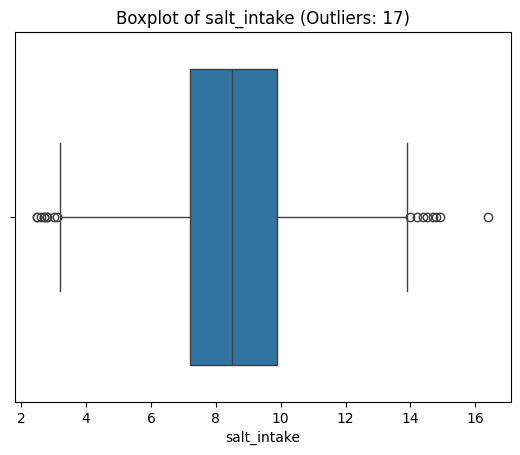

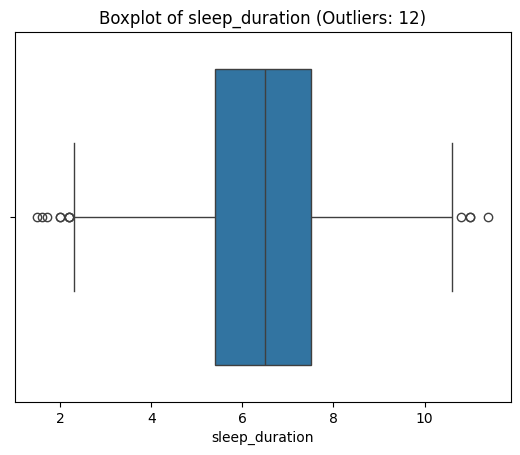

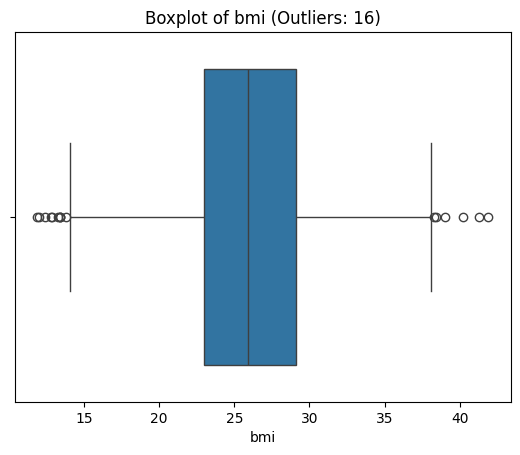

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in outlier_report.keys():  # outlier_report = your dictionary
    sns.boxplot(data=data, x=col)
    plt.title(f'Boxplot of {col} (Outliers: {outlier_report[col]})')
    plt.show()

- The outliers are not extreme values and are valid data points. They will not be removed

## ENCODING AND NORMALIZATION

### FEATURE ENCODING

In [24]:
data.head(10)

,age,salt_intake,stress_score,bp_history,sleep_duration,bmi,medication,family_history,exercise_level,smoking_status,has_hypertension
0,69,8.0,9,Normal,6.4,25.8,None,Yes,Low,Non-Smoker,1
1,32,11.7,10,Normal,5.4,23.4,None,No,Low,Non-Smoker,0
2,78,9.5,3,Normal,7.1,18.7,None,No,Moderate,Non-Smoker,0
3,38,10.0,10,Hypertension,4.2,22.1,ACE Inhibitor,No,Low,Non-Smoker,1
4,41,9.8,1,Prehypertension,5.8,16.2,Other,No,Moderate,Non-Smoker,0
5,20,10.8,3,Hypertension,5.2,21.9,Beta Blocker,Yes,High,Non-Smoker,1
6,39,8.9,0,Normal,7.8,27.6,Beta Blocker,Yes,High,Non-Smoker,0
7,70,5.9,1,Hypertension,7.2,25.8,None,No,Moderate,Non-Smoker,1
8,19,9.3,7,Normal,4.7,36.5,Beta Blocker,Yes,Low,Smoker,1
9,47,7.2,5,Normal,6.2,24.3,None,No,High,Non-Smoker,0


In [25]:
# Select only categorical columns (non-numeric)
cat_cols = data.select_dtypes(include=['object', 'category']).columns

# Print unique values for each categorical column
for col in cat_cols:
    unique_vals = data[col].unique()
    print(f"Column: '{col}'")
    print(f"Unique values ({len(unique_vals)}): {unique_vals}\n")

Column: 'bp_history'
Unique values (3): ['Normal' 'Hypertension' 'Prehypertension']

Column: 'medication'
Unique values (5): ['None' 'ACE Inhibitor' 'Other' 'Beta Blocker' 'Diuretic']

Column: 'family_history'
Unique values (2): ['Yes' 'No']

Column: 'exercise_level'
Unique values (3): ['Low' 'Moderate' 'High']

Column: 'smoking_status'
Unique values (2): ['Non-Smoker' 'Smoker']



In [26]:
# Encoding
prior_hypertension_hist_map = {'Normal': 0, 'Hypertension':1, 'Prehypertension':2}
data["bp_history"] = data["bp_history"].map(prior_hypertension_hist_map)

meds_map = {'Beta Blocker':0, 'ACE Inhibitor':1, 'Diuretic':2, 'Other':3, 'None':4}
data["medication"] = data["medication"].map(meds_map)

data['family_history'] = data['family_history'].map({'Yes': 1, 'No': 0})

exercise_map = {'Low': 0, 'Moderate': 1, 'High': 2}
data['exercise_level'] = data['exercise_level'].map(exercise_map)

data['smoking_status'] = data['smoking_status'].map({'Smoker': 1, 'Non-Smoker': 0})

In [27]:
data.head(10)

,age,salt_intake,stress_score,bp_history,sleep_duration,bmi,medication,family_history,exercise_level,smoking_status,has_hypertension
0,69,8.0,9,0,6.4,25.8,4,1,0,0,1
1,32,11.7,10,0,5.4,23.4,4,0,0,0,0
2,78,9.5,3,0,7.1,18.7,4,0,1,0,0
3,38,10.0,10,1,4.2,22.1,1,0,0,0,1
4,41,9.8,1,2,5.8,16.2,3,0,1,0,0
5,20,10.8,3,1,5.2,21.9,0,1,2,0,1
6,39,8.9,0,0,7.8,27.6,0,1,2,0,0
7,70,5.9,1,1,7.2,25.8,4,0,1,0,1
8,19,9.3,7,0,4.7,36.5,0,1,0,1,1
9,47,7.2,5,0,6.2,24.3,4,0,2,0,0


### FEATURE CORRELATIONS

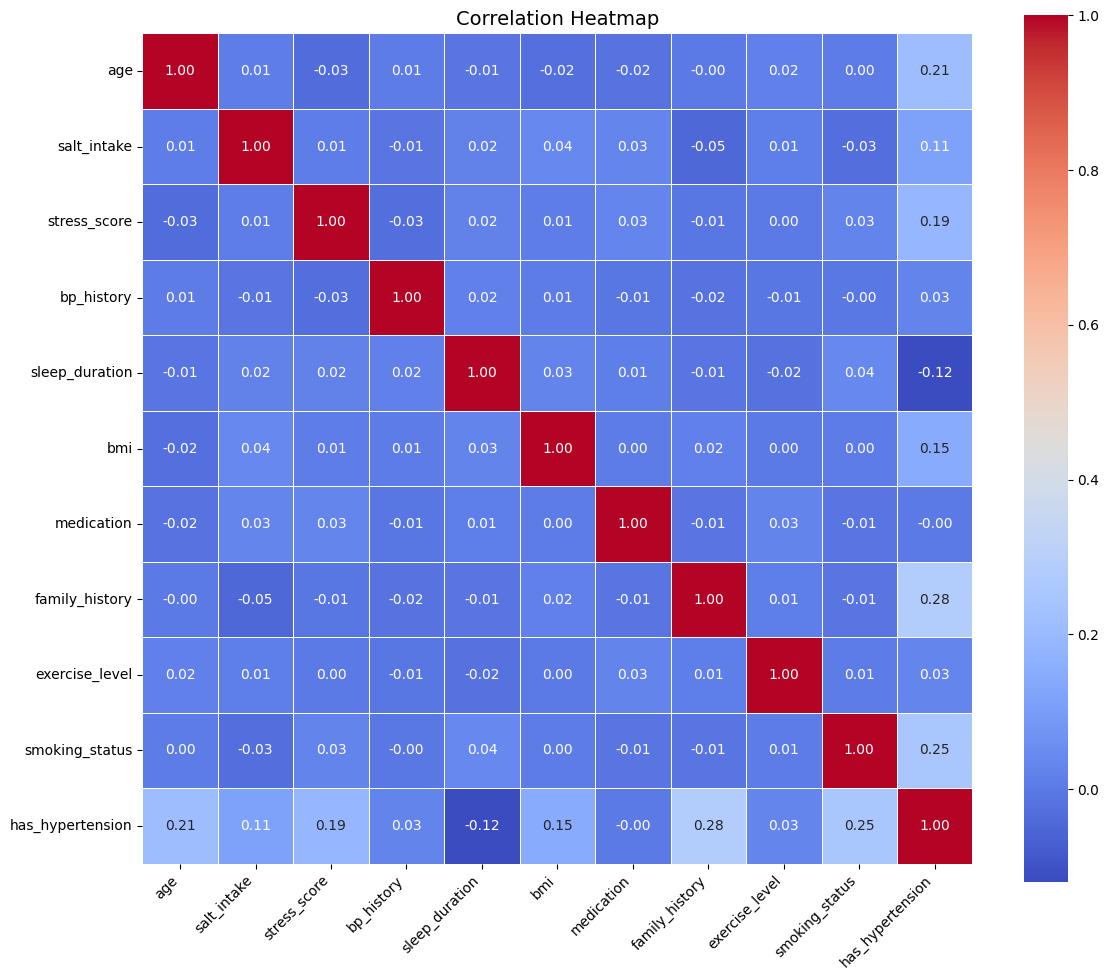

In [28]:
# sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
# Set the figure size (width, height)
plt.figure(figsize=(12, 10))

# Customize the heatmap
heatmap = sns.heatmap(
    data.corr(),
    annot=True,
    annot_kws={'size': 10},
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    square=True
)

# Rotate x-axis labels for better readability
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

# Add title
plt.title("Correlation Heatmap", fontsize=14)

# Ensure tight layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

- There are barely any feature-to-feature correlations and most features with strong influencial correlations to the target have correlation values greater than or equal to 0.1 (positive or negative relations that is).
- The features with less influencial correlations like: medication, exercising_level and bp_history, will be removed. This contrasts to my earlier analysis of exercising levels and prior hypertension history being influencing factors.

In [29]:
data.drop(columns=['medication', 'bp_history', 'exercise_level'], inplace=True)
data.head(10)

,age,salt_intake,stress_score,sleep_duration,bmi,family_history,smoking_status,has_hypertension
0,69,8.0,9,6.4,25.8,1,0,1
1,32,11.7,10,5.4,23.4,0,0,0
2,78,9.5,3,7.1,18.7,0,0,0
3,38,10.0,10,4.2,22.1,0,0,1
4,41,9.8,1,5.8,16.2,0,0,0
5,20,10.8,3,5.2,21.9,1,0,1
6,39,8.9,0,7.8,27.6,1,0,0
7,70,5.9,1,7.2,25.8,0,0,1
8,19,9.3,7,4.7,36.5,1,1,1
9,47,7.2,5,6.2,24.3,0,0,0


In [30]:
# Save cleaned data as csv
data.to_csv("cleaned_hypertension.csv", index=False)

# MODEL TRAINING AND EVALUATION

In [31]:
# Split the data in train and validation sets
x = data.drop('has_hypertension', axis=1)
y = data['has_hypertension']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Define the model
model = RandomForestClassifier(class_weight='balanced')
model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_val_scaled)
pred_score = f1_score(y_val, y_pred)

print(f"F1 Score: {pred_score}")

F1 Score: 0.7719298245614035


# HYPERPARAMETER TUNING

In [32]:
# Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1_weighted',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(x_train_scaled, y_train)

# Best model evaluation on validation set
best_model = random_search.best_estimator_
y_val_pred = best_model.predict(x_val_scaled)

print("Best params:", random_search.best_params_)
print("Validation F1 score (weighted):", f1_score(y_val, y_val_pred, average='weighted'))
print(classification_report(y_val, y_val_pred, zero_division=0))


Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None}
Validation F1 score (weighted): 0.7730148041651577
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       192
           1       0.81      0.73      0.77       205

    accuracy                           0.77       397
   macro avg       0.78      0.77      0.77       397
weighted avg       0.78      0.77      0.77       397



# SAVE MODEL AND SCALER

In [33]:
# Save the trained model
joblib.dump(best_model, 'hypertension_model.pkl')
print("Succesfully saved best model!")

# Save the scaler used on training data
joblib.dump(scaler, 'hypertension_scaler.pkl')
print("Succesfully saved model scaler!")

Succesfully saved best model!
Succesfully saved model scaler!
